## COMP262 - Assignment 2 - Exercise 2
### Nestor Romero Leon - 301133331

In [1]:
# general imports
import os
import sys
import re
import json
import random
import numpy as np
import pandas as pd
import pickle

In [2]:
# nlp specific imports
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras.layers import Dense, GlobalAveragePooling1D, Embedding
from keras.models import Sequential


## Load Data

In [3]:
dataset = json.load(open('nestor_intents.json', encoding='utf-8'))

intents  = [] # holds the original list of intents >> len( number_of_intents )
responses = [] # holds the original responses for each intent >> len( number_of_intents )
patterns = [] # list of all patterns in a single list
labels = [] # list of the matching intent for each pattern matched by index with patterns

for record in dataset['intents']:
    
    intent = record['tag']
    intents.append(intent)
    responses.append(record['responses'])
    
    for pattern in record['patterns']: 
       patterns.append(pattern)
       labels.append(intent)

# print(intents)
# print(responses)    
# print(patterns)
# print(labels)
print(len(intents))
print(len(patterns))
print(len(labels))

8
28
28


## Artificially increment dataset size (optional)

In [4]:
'''
    This variable helps control the proportion in which to artificially increase the dataset size
    total_records = records * DATA_MULTI_FACTOR
'''
DATA_MULTI_FACTOR = 5

temp_patterns = []
temp_labels = []

for _ in range(DATA_MULTI_FACTOR):
    temp_patterns.extend(patterns)
    temp_labels.extend(labels)

if DATA_MULTI_FACTOR > 0:
    patterns = temp_patterns
    labels = temp_labels

print(len(patterns))
print(len(labels))
print(patterns[-5:])
print(labels[-5:])

140
140
['The cashier was sleeping', 'A call center agent was awful', 'How can I contact a service agent', 'How can I track my complaint', 'Where can I send all the details of my complaint']
['complaint_service', 'complaint_service', 'additional_information', 'additional_information', 'additional_information']


## Data Preprocessing

In [5]:
# Encoding the intents
label_encoder = LabelEncoder()
label_encoder.fit(intents)

encoded_labels = label_encoder.transform(labels)
print(label_encoder.classes_)
print(encoded_labels[-5:])

['additional_information' 'complaint_balance' 'complaint_service'
 'complaint_technical' 'greeting' 'submit_complaint' 'submit_problem'
 'thanks']
[2 2 0 0 0]


In [6]:
# Tokenizing the patterns (aux function >> lowercasing, punctuation)
# Create sequences

#VOCABULARY_SIZE = 1000
tokenizer = Tokenizer()

def preprocess_phrase(phrase):
    phrase = str.lower(phrase.strip())
    phrase = re.sub(r'[^\w\s]', '', phrase)
    return phrase


# The patterns for each intents are organized in a single list to tokenize the texts
sentences = []
max_words_phrase = 0
for pattern in patterns:
    # clean up pattern phrases 1. lowercasing and removing punctuation
    proc_pattern = preprocess_phrase(pattern)
    sentences.append(proc_pattern)

    # count words to find max
    num_words = len(proc_pattern.split(' '))
    if(num_words > max_words_phrase):
        max_words_phrase = num_words

# print(len(sentences))
tokenizer.fit_on_texts(sentences)
print(f'Vocabulary Size: {len(tokenizer.word_index)}')
vocabulary_size = len(tokenizer.word_index)
pattern_vocabulary_index = tokenizer.word_index
# print(tokenizer.word_index)

# Keep the vectors for each intent matched by index
vectors = tokenizer.texts_to_sequences(patterns)
print(vectors[0:5])

# Keep the sequences for each intent matched by index
sequences = pad_sequences(vectors, maxlen=vocabulary_size)
print(sequences[0:5])
print(f'{sequences.shape} - {encoded_labels.shape}')

Vocabulary Size: 68
[[23], [24], [4, 25, 14], [26], [9, 27, 15]]
[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 23]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 24]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4 25 14]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 26]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0 

In [7]:
# Create training and test data sets

# Shuffle indexes for data and labels
indexes = np.arange(sequences.shape[0])
random.seed(301133331)
np.random.shuffle(indexes)
sequences = sequences[indexes]
final_labels = encoded_labels[indexes]

# Split data 70 - 30
training_size = int(sequences.shape[0] * 0.7)
x_train = sequences[:training_size]
y_train = final_labels[:training_size]
x_test = sequences[training_size:]
y_test = final_labels[training_size:]

print(f'x_train shape: {x_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'x_test_shape: {x_test.shape}')
print(f'y_test_shape: {y_test.shape}')
#print(np.unique(y_train, return_counts=True))

x_train shape: (98, 68)
y_train shape: (98,)
x_test_shape: (42, 68)
y_test_shape: (42,)


## Modeling

In [8]:
# Creating deep learning model architecture as a ANN with Keras

VOCABULARY_LIMIT = 1000
EMBEDDING_DIMENSIONS = 16 
INPUT_LENGHT = 20

complaint_intent_model = Sequential()
# Embedding layer as input
# complaint_intent_model.add(embedding_layer)
complaint_intent_model.add(Embedding(input_dim = VOCABULARY_LIMIT, 
                                     output_dim = EMBEDDING_DIMENSIONS,
                                     input_length = vocabulary_size))
# Global Average Pooling Layer
complaint_intent_model.add(GlobalAveragePooling1D())
# Two dense layers with 16 units and activation type relu
complaint_intent_model.add(Dense(EMBEDDING_DIMENSIONS, activation='relu'))
complaint_intent_model.add(Dense(EMBEDDING_DIMENSIONS, activation='relu'))
# Final dense layer with units = num classes / intents
complaint_intent_model.add(Dense(len(intents), activation='softmax'))

# Model compilation
complaint_intent_model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

complaint_intent_model.summary()

# Train the model -  Train data
complaint_intent_model.fit(x_train, y_train, epochs=500, verbose=2)

# Evaluate on test set:
loss_score, accuracy = complaint_intent_model.evaluate(x_test, y_test, verbose=None)
print()
print(f'Test loss score: {loss_score}')
print(f'Test accuracy: {accuracy}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 68, 16)            16000     
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 16,680
Trainable params: 16,680
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
4/4 - 1s - loss: 2.0788 - accuracy: 0.1735
Epoch 2/500
4/4 - 0s - loss: 2.0775 - accuracy: 0.1735
Epoch 3/

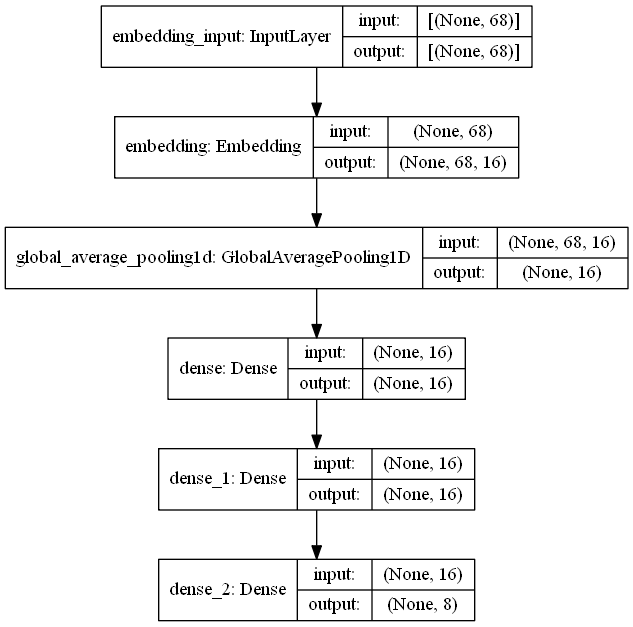

In [9]:
plot_model(complaint_intent_model, 'complaint_intent_model.png', show_shapes = True)

## Saving objects as pickles

In [10]:
# Save tokenizer
pickle.dump(tokenizer, open("tokenizer.pkl", "wb" )) 

# Save encoder
pickle.dump(label_encoder, open("label_encoder.pkl", "wb" )) 
            
# Save model
complaint_intent_model.save("complaint_intent_model.model")

INFO:tensorflow:Assets written to: complaint_intent_model.model\assets
